Old one got too messy (see: Cleaner_Plot_Tests.ipynb for previous rendition), this new one created on 01/11/2024.
-- Julia Buhrman (01/11/2024)

I forgot to include ka 2 so maybe that will help reconcile the difference in points between the bearings and the scan locations?
Nope it didn't

In [1]:
# import necessary stuff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import coords
import xarray as xr
import pyart
from datetime import timedelta
from radarcalc import *
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import metpy
import metpy.plots
from metpy.units import units
import cartopy.crs as ccrs
import cartopy
import gc


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



C:\Users\julia\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
C:\Users\julia\Desktop\Research\radarcalc.py:81: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit


In [2]:
# bring in the data, in this case it's from Morton

# gps data for first ka
ka1gps = pd.read_csv('C:/Users/julia/Desktop/Research/GPS_Ka1_20220523.txt')
# scan data for first ka
ka1scan = pd.read_csv('C:/Users/julia/Desktop/Research/20220523_Ka1_scan_log.txt', dtype=str,
                     parse_dates=[0])

# dealiased vad data created from VADS.ipynb for ka 1, but not bearing corrected
vad_fileska1 = sorted(glob.glob('C:/Users/julia/Desktop/Research/product_raw_ka1/*.nc'))

# sanity checks to make sure they're loading in:
#print(vad_fileska1)
#print(ka1gps)

In [3]:
np.size(vad_fileska1)

38

In [4]:
np.size(ka1gps['Latitude'])

31906

In [5]:
# data for ka 2

ka2gps = pd.read_csv('C:/Users/julia/Desktop/Research/GPS_Ka2_20220523.txt')
# scan data for first ka
ka2scan = pd.read_csv('C:/Users/julia/Desktop/Research/20220523_Ka2_scan_log.txt', dtype=str,
                     parse_dates=[0])

# dealiased vad data created from VADS.ipynb for ka 1, but not bearing corrected
vad_fileska2 = sorted(glob.glob('C:/Users/julia/Desktop/Research/product_raw_ka2/*.nc'))

# sanity checks to make sure they're loading in:
#print(vad_fileska2)
#print(ka2gps)

Make the data into arrays via xarray:

In [6]:
#x_vad_fileska1 = xr.open_mfdataset(vad_fileska1[:37])

Now that the data is loaded in, we need to create a function that converts the distance from the storm to the vehicle from (lat,lon) into meters.

In [7]:
#Read in storm location csv

storm_location = pd.read_csv(r"C:\Users\julia\Desktop\Research\StormLocationMorton.csv", header=0)
storm_location['Date']=storm_location['Date'].astype(str).str.zfill(8)
storm_location['Time']=storm_location['Time'].astype(str).str.zfill(8)
storm_location['datetime'] = pd.to_datetime(storm_location['Date'].astype(str)+storm_location['Time'].astype(str),format='%m/%d/%Y%H:%M:%S')

storm_location['Lon'] = storm_location['Lon'].astype(str).str.zfill(8)
storm_lon = storm_location['Lon'].astype(float) # .astype(float) changes it from string to float since you cant operate on strings

print(storm_lon)

storm_location['Lat'] = storm_location['Lat'].astype(str).str.zfill(8) 
storm_lat = storm_location['Lat'].astype(float)

print(storm_lat)
#print(storm_location)

0    -103.098
1    -103.073
2    -103.061
3    -103.058
4    -103.054
       ...   
59   -102.204
60   -102.155
61   -102.119
62   -102.105
63   -102.067
Name: Lon, Length: 64, dtype: float64
0     33.497
1     33.510
2     33.522
3     33.553
4     33.584
       ...  
59    33.650
60    33.650
61    33.650
62    33.650
63    33.650
Name: Lat, Length: 64, dtype: float64


In [8]:
storm_location['Date']

0     5/23/2022
1     5/23/2022
2     5/23/2022
3     5/23/2022
4     5/23/2022
        ...    
59    5/24/2022
60    5/24/2022
61    5/24/2022
62    5/24/2022
63    5/24/2022
Name: Date, Length: 64, dtype: object

In [9]:
storm_location['Time']

0     21:55:00
1     22:00:00
2     22:05:00
3     22:10:00
4     22:15:00
        ...   
59    02:50:00
60    02:55:00
61    03:00:00
62    03:05:00
63    03:10:00
Name: Time, Length: 64, dtype: object

In [10]:
# from stackoverflow (https://stackoverflow.com/questions/639695/how-to-convert-latitude-or-longitude-to-meters)
# originally in javascript
def measure(lat1, lon1, lat2, lon2):  # generally used geo measurement function
    R = 6378.137 # Radius of earth in KM
    dLat = lat2 * np.pi / 180 - lat1 * np.pi / 180;
    dLon = lon2 * np.pi / 180 - lon1 * np.pi / 180;
    a = np.sin(dLat/2) * np.sin(dLat/2) + np.cos(lat1 * np.pi / 180) * np.cos(lat2 * np.pi / 180) * np.sin(dLon/2) * np.sin(dLon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    #d_meters = d * 1000
    return d # km

In [11]:
# example on how to grab lat and lon, these are from the gps

lat=ka1gps.Latitude # <== easier way to grab column
lon=ka1gps.Longitude
print(lat)
print(lon)

0        33.588547
1        33.588547
2        33.588547
3        33.588547
4        33.588547
           ...    
31901    33.589625
31902    33.589630
31903    33.589645
31904    33.589662
31905    33.589678
Name: Latitude, Length: 31906, dtype: float64
0       -102.031783
1       -102.031783
2       -102.031783
3       -102.031783
4       -102.031783
            ...    
31901   -102.032235
31902   -102.032227
31903   -102.032210
31904   -102.032200
31905   -102.032198
Name: Longitude, Length: 31906, dtype: float64


In [12]:
lat_ka2=ka2gps.Latitude # <== easier way to grab column
lon_ka2=ka2gps.Longitude
print(lat_ka2)
print(lon_ka2)

0        33.581025
1        33.580842
2        33.580660
3        33.580478
4        33.580298
           ...    
22101    33.592712
22102    33.592775
22103    33.592828
22104    33.592868
22105    33.592895
Name: Latitude, Length: 22106, dtype: float64
0       -102.026500
1       -102.026495
2       -102.026492
3       -102.026490
4       -102.026488
            ...    
22101   -102.032913
22102   -102.032918
22103   -102.032937
22104   -102.032970
22105   -102.033012
Name: Longitude, Length: 22106, dtype: float64


In [13]:
#lat_vads_ka1 = vad_fileska1.Latitude
#lon_vads_ka1 = vad_fileska1.Longitude

In [14]:
lat_scans_ka1 = ka1scan.Latitude.astype(float)
lon_scans_ka1 = ka1scan.Longitude.astype(float)

In [15]:
print(lat_scans_ka1)
print(lon_scans_ka1)

0      33.593816
1      33.593902
2      33.593976
3      33.594052
4      33.594721
         ...    
302    33.592530
303    33.592530
304    33.592530
305    33.592530
306    33.592530
Name: Latitude, Length: 307, dtype: float64
0     -102.339719
1     -102.346550
2     -102.353427
3     -102.359624
4     -102.361347
          ...    
302   -102.035702
303   -102.035702
304   -102.035702
305   -102.035702
306   -102.035702
Name: Longitude, Length: 307, dtype: float64


In [16]:
dfs_list = []
for i in np.arange(0,len(storm_location)):
    cms = measure(lat[i], lon[i], storm_lat[i], storm_lon[i])
    dfs_list.append(cms)

    # dfs: distance from storm

In [17]:
#print(dfs_list)

In [18]:
np.shape(dfs_list)

(64,)

In [19]:
dfs_list_ka2 = []
for i in np.arange(0,len(storm_location)):
    cms = measure(lat[i], lon[i], storm_lat[i], storm_lon[i])
    dfs_list_ka2.append(cms)

In [20]:
np.shape(dfs_list_ka2)

(64,)

There are 64 terms in the distance from storm array.

Let's try the scan lat, lon instead of the gps:

In [21]:
dfs_list_scan_ka1 = []
for i in np.arange(0,len(storm_location)):
    cms = measure(lat_scans_ka1[i], lon_scans_ka1[i], storm_lat[i], storm_lon[i])
    dfs_list_scan_ka1.append(cms)

In [22]:
np.shape(dfs_list_scan_ka1)

(64,)

Let's use the vad locations instead of the gps ones:

In [23]:
dfs_vads_list_ka1 = []
for i in np.arange(0,len(storm_location)):
    cms = measure(lat[i], lon[i], storm_lat[i], storm_lon[i])
    dfs_vads_list_ka1.append(cms)

    # dfs: distance from storm

Now that we have our distance from the storm in meters-- aka our r -- we need theta.
Theta is the bearing from the VADs.

In [24]:
bearing_list = []

# Code from Alex S and Josh O
# Fixing the bearing
from datetime import datetime

# gps data for first ka
ka1gps = pd.read_csv('C:/Users/julia/Desktop/Research/GPS_Ka1_20220523.txt')
ka1gps=ka1gps.astype(str)
# scan data for first ka
ka1scan = pd.read_csv('C:/Users/julia/Desktop/Research/20220523_Ka1_scan_log.txt', dtype=str,
                     parse_dates=[0])
# dealiased vad data created from VADS.ipynb for ka 1, but not bearing corrected
vad_fileska1 = sorted(glob.glob('C:/Users/julia/Desktop/Research/product_raw_ka1/*.nc'))

#print(ka1gps)

for thefile in vad_fileska1[:37]:

    radar = pyart.io.read_cfradial(thefile)
    print(thefile,radar.fixed_angle['data'])
    
    # selects a column and uses it to tell program how to run through data
    
    ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]'] 
    ka1gps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]']]
    beginscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = ka1gps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})

    speed = dfscan['Velocity[knots]'].astype(float).mean()
        
    #Get Bearing from deployment log or gps file
    if int(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0:
        bearing = float(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0])
    else:
        bearing = dfscan['Bearing[degrees]'].mean()
        
    #Manual Corrections
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
    
    #print('Bearing used: '+str(bearing))
    
    lat_vads = dfscan['Latitude'].astype(float)
    lon_vads = dfscan['Longitude'].astype(float)
    
    #print(lat)
    #print(lon)
    #Bearing Correction
    radar.azimuth['data']+=(bearing)%360
    #print(bearing)
    
    # add all bearings from loop to list
    bearing_list.append(bearing)
    
print(bearing_list)

C:/Users/julia/Desktop/Research/product_raw_ka1\Ka12205232.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523205632.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523205701.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523205730.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523205759.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523205828.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523205857.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523205926.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523205955.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523221718.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523222551.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Res

In [25]:
# for ka 2

bearing_list_ka2 = []

# Code from Alex S and Josh O
# Fixing the bearing
from datetime import datetime

# gps data for first ka
ka2gps = pd.read_csv('C:/Users/julia/Desktop/Research/GPS_Ka2_20220523.txt')
ka2gps=ka2gps.astype(str)
# scan data for first ka
ka2scan = pd.read_csv('C:/Users/julia/Desktop/Research/20220523_Ka2_scan_log.txt', dtype=str,
                     parse_dates=[0])
# dealiased vad data created from VADS.ipynb for ka 1, but not bearing corrected
vad_fileska2 = sorted(glob.glob('C:/Users/julia/Desktop/Research/product_raw_ka2/*.nc'))

#print(ka1gps)

for thefile in vad_fileska2[:64]:

    radar = pyart.io.read_cfradial(thefile)
    print(thefile,radar.fixed_angle['data'])
    
    # selects a column and uses it to tell program how to run through data
    
    ka2gps['ddmmyy']+ka2gps['hhmmss[UTC]'] 
    ka2gps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in ka2gps['ddmmyy']+ka2gps['hhmmss[UTC]']]
    beginscanindex = ka2gps.loc[ka2gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = ka2gps.loc[ka2gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = ka2gps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})

    speed = dfscan['Velocity[knots]'].astype(float).mean()
        
    #Get Bearing from deployment log or gps file
    if int(ka2scan.loc[ka2scan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0:
        bearing = float(ka2scan.loc[ka2scan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0])
    else:
        bearing = dfscan['Bearing[degrees]'].mean()
        
    #Manual Corrections
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
    
    #print('Bearing used: '+str(bearing))
    
    lat_vads = dfscan['Latitude'].astype(float)
    lon_vads = dfscan['Longitude'].astype(float)
    
    #print(lat)
    #print(lon)
    #Bearing Correction
    radar.azimuth['data']+=(bearing)%360
    #print(bearing)
    
    # add all bearings from loop to list
    bearing_list_ka2.append(bearing)
    
print(bearing_list_ka2)

C:/Users/julia/Desktop/Research/product_raw_ka2\Ka2220523221144.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka2\Ka2220523221214.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka2\Ka2220523221244.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka2\Ka2220523221314.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka2\Ka2220523221345.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka2\Ka2220523221414.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka2\Ka2220523221445.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka2\Ka2220523221515.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka2\Ka2220523221545.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka2\Ka2220523221615.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka2\Ka2220523221646.nc [37.001953 45.      ]
C:/Users/julia/Deskto

In [26]:
np.size(vad_fileska2)

85

In [27]:
# get the storm motion (in degrees)
# Code from Alex S and Josh O

#Calculate storm motion 

decimalhour=[]
decimalsec=[]
for i in np.arange(0,len(storm_location),1):
    (h, m, s) = storm_location.loc[i].Time.split(':')
    result = int(h) + int(m)/60 + int(s)/3600
    result1 = int(h) * 3600 + int(m) * 60 + int(s)
    decimalsec.append(result1)
    decimalhour.append(result)
storm_location['decimalhour']=decimalhour
storm_location['decimalsec']=decimalsec
storm_decimalsec=storm_location.decimalsec.astype(float)


from math import sin, cos, sqrt, atan2, radians

def calc_velocity(lat1,lon1,lat2,lon2,time1,time2):
    R = 6371 # Radius of the earth in km
    dLat = radians(lat2-lat1)
    dLon = radians(lon2-lon1)
    rLat1 = radians(lat1)
    rLat2 = radians(lat2)
    a = sin(dLat/2) * sin(dLat/2) + cos(rLat1) * cos(rLat2) * sin(dLon/2) * sin(dLon/2) 
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = R * c * 1000 # Distance in m
    return d / (time2 - time1)

def get_bearing(lat1, long1, lat2, long2):
    dLon = (long2 - long1)
    x = cos(radians(lat2)) * sin(radians(dLon))
    y = cos(radians(lat1)) * sin(radians(lat2)) - sin(radians(lat1)) * cos(radians(lat2)) * cos(radians(dLon))
    brng = np.arctan2(x,y)
    brng = (np.degrees(brng)+180) % 360
    return brng

velocity1=[]
direction1=[]
for i in np.arange(0,len(storm_location)-1,1):
    velocity = calc_velocity(storm_lat[i],storm_lon[i],
                             storm_lat[i+1],storm_lon[i],
                             storm_decimalsec[i],storm_decimalsec[i+1])
    velocity1.append(velocity)
    direction = get_bearing(storm_lat[i],storm_lon[i],
                             storm_lat[i+1],storm_lon[i+1])
    direction1.append(direction)
velocity1 = np.append([np.nan],velocity1)
direction1 = np.append([np.nan],direction1)
storm_location['storm_vel']=velocity1 #m/s
storm_location['storm_dir']=direction1 #deg

#print(velocity1)
#print(direction1)

In [28]:
np.size(velocity1)

64

In [29]:
np.size(direction1)

64

As the bearing and storm location arrays do not have the same number of indeces, I cannot assume the storm location and bearing indeces correlate based on their position in the arrays. I will instead take the average of both to use.

In [30]:
# need degrees (so the direction) of the storm
# find storm velocity and subtract from points getting plotted?
# then plot both degree shift on the axis and the points after storm motion has been subtracted?
# convert to dataframe
# df for data frame so i can use pandas to drop the nan. cant average with nan in list
directiondf = pd.DataFrame(direction1)

direction_corrected = directiondf.dropna()

avg_storm_direction = np.average(direction_corrected)

print(avg_storm_direction) # avg storm direction in degrees

247.85901642897275


In [31]:
velocitydf = pd.DataFrame(velocity1)

velocity_corrected = velocitydf.dropna()

avg_storm_velocity = np.average(velocity_corrected)

In [32]:
print(avg_storm_velocity)

3.4770477061870015


In [33]:
# alright laptop... you can do this...
# get bearings of ALL VADs

bearing_list2 = []

# Code from Alex S and Josh O
# Fixing the bearing
from datetime import datetime

# gps data for first ka
ka1gps = pd.read_csv('C:/Users/julia/Desktop/Research/GPS_Ka1_20220523.txt')
ka1gps=ka1gps.astype(str)
# scan data for first ka
ka1scan = pd.read_csv('C:/Users/julia/Desktop/Research/20220523_Ka1_scan_log.txt', dtype=str,
                     parse_dates=[0])
# dealiased vad data created from VADS.ipynb for ka 1, but not bearing corrected
vad_fileska1 = sorted(glob.glob('C:/Users/julia/Desktop/Research/product_raw_ka1/*.nc'))

#print(ka1gps)

# !!! 37 is the last working index before it goes out of range !!!
# there are only 37 netcdf vad files

for thefile in (vad_fileska1[:37]):

    radar = pyart.io.read_cfradial(thefile)
    print(thefile,radar.fixed_angle['data'])
    
    # selects a column and uses it to tell program how to run through data
    
    ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]'] 
    ka1gps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]']]
    beginscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = ka1gps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})

    speed = dfscan['Velocity[knots]'].astype(float).mean()
        
    #Get Bearing from deployment log or gps file
    if int(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0:
        bearing = float(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0])
    else:
        bearing = dfscan['Bearing[degrees]'].mean()
        
    #Manual Corrections
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
    
    #print('Bearing used: '+str(bearing))
    
    lat_vads = dfscan['Latitude'].astype(float)
    lon_vads = dfscan['Longitude'].astype(float)
    
    #print(lat)
    #print(lon)
    #Bearing Correction
    radar.azimuth['data']+=(bearing)%360
    #print(bearing)
    
    # add all bearings from loop to list
    bearing_list2.append(bearing)
    
print(bearing_list2)

C:/Users/julia/Desktop/Research/product_raw_ka1\Ka12205232.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523205632.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523205701.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523205730.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523205759.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523205828.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523205857.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523205926.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523205955.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523221718.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523222551.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Res

In [34]:
np.shape(bearing_list2)

(37,)

**The bearing size does not match the size of the distances from the storm array! There are 64 in the distance from storm array but only 37 for the bearing!** Points will thus be missing from the graph, especially the closer ones!

Why is there only 37 indeces for the bearing? when attempting to run the vad list in its entirety, instead of finishing at 37 indeces, after 37 there is an error that something is out of bounds for axis 0 or something. are there less bearing calculations than vads? were some cut out for quality control?

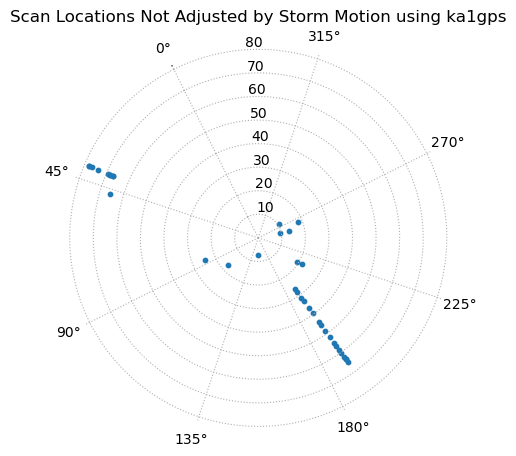

In [35]:
# bring in the figure

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(projection = 'polar')
ax.set_rmax(2)
#ax.set_rticks(distance_grid)
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True, linestyle = ':') # makes grid lines dotted
#ax.set_theta_zero_location('W', avg_storm_direction) # what is the N, S, E, W good for?
#ax.set_theta_offset(avg_storm_direction)
ax.set_title("Scan Locations Not Adjusted by Storm Motion using ka1gps")
ax.plot()
ax.set_theta_offset(90)

# now that we have the figure set up, we can plot on it
# r --> great circle distance from lat and lon of storm to lat and lon of vehicle
# theta --> corrected bearing
# in polar plots the order of plotting is (theta, r)
theta = bearing_list2
r = dfs_list[27:64] # 37 of the dfs indeces, these inclue the last of the list, so they're closer to the storm

ax.scatter(theta, r, s = 10) # s changes point size

plt.show()

Flip the plot so 45 is on the right side

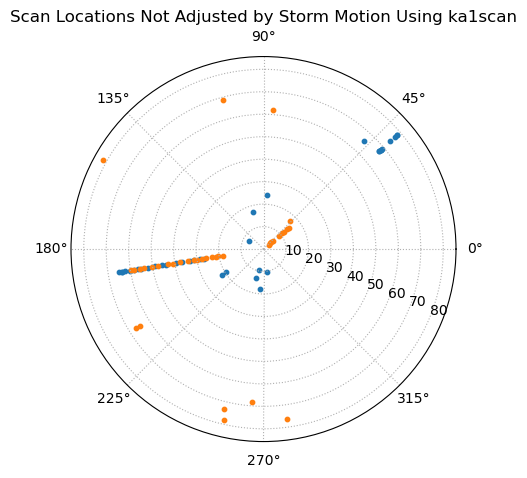

In [36]:
# bring in the figure

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(projection = 'polar')
ax.set_rmax(2)
#ax.set_rticks(distance_grid)
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True, linestyle = ':') # makes grid lines dotted
#ax.set_theta_zero_location('W', avg_storm_direction) # what is the N, S, E, W good for?
#ax.set_theta_offset(avg_storm_direction)
ax.set_title("Scan Locations Not Adjusted by Storm Motion Using ka1scan")
ax.plot()

# now that we have the figure set up, we can plot on it
# r --> great circle distance from lat and lon of storm to lat and lon of vehicle
# theta --> corrected bearing
# in polar plots the order of plotting is (theta, r)
theta = bearing_list2
r = dfs_list[27:64] # 37 of the dfs indeces, these inclue the last of the list, so they're closer to the storm

theta2 = bearing_list2
r2 = dfs_list_scan_ka1[27:64]

ax.scatter(theta, r, s = 10) # s changes point size
ax.scatter(theta2, r2, s = 10)

plt.show()

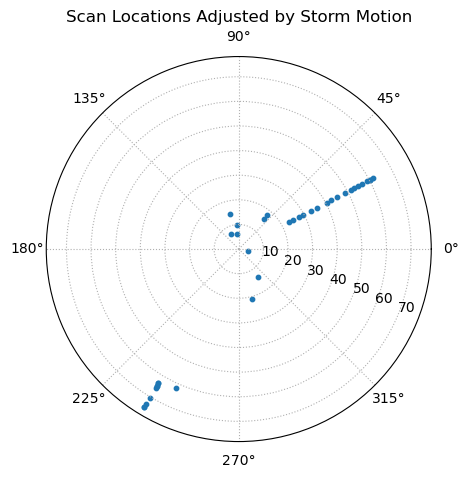

In [37]:
# bring in the figure

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(projection = 'polar')
ax.set_rmax(2)
#ax.set_rticks(distance_grid)
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True, linestyle = ':') # makes grid lines dotted
#ax.set_theta_zero_location('W', avg_storm_direction) # what is the N, S, E, W good for?
#ax.set_theta_offset(avg_storm_direction)
ax.set_title("Scan Locations Adjusted by Storm Motion")
ax.plot()

# now that we have the figure set up, we can plot on it
# r --> great circle distance from lat and lon of storm to lat and lon of vehicle
# theta --> corrected bearing
# in polar plots the order of plotting is (theta, r)
theta = bearing_list2 - avg_storm_direction
r = dfs_list[27:64] - avg_storm_velocity

ax.scatter(theta, r, s = 10) # s changes point size

plt.show()

I'm trying to move the points like how they move a hodograph so that it's storm-relative, see Cameron Nixon's Hodograph blog page where he makes the hodograph go from ground-relative to storm-relative.

Note that the indeces from 0 to 36 of the vad location array are not plotted. I cannot plot them as I have no bearing to associate them with...

I also do not know if the bearings I plotted with the distances are even the proper bearings.

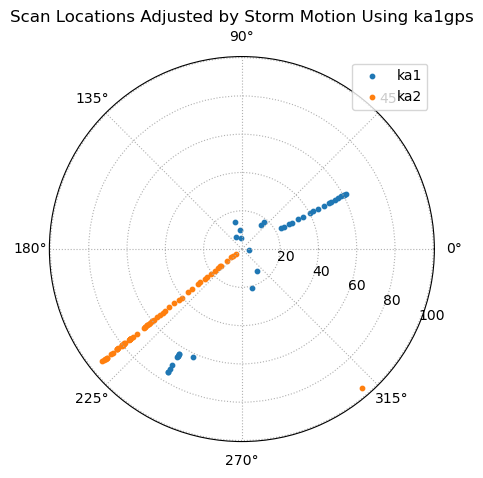

In [38]:
# bring in the figure

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(projection = 'polar')
ax.set_rmax(2)
#ax.set_rticks(distance_grid)
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True, linestyle = ':') # makes grid lines dotted
#ax.set_theta_zero_location('W', avg_storm_direction) # what is the N, S, E, W good for?
#ax.set_theta_offset(avg_storm_direction)
ax.set_title("Scan Locations Adjusted by Storm Motion Using ka1gps")
ax.plot()

# now that we have the figure set up, we can plot on it
# r --> great circle distance from lat and lon of storm to lat and lon of vehicle
# theta --> corrected bearing
# in polar plots the order of plotting is (theta, r)
theta = bearing_list2 - avg_storm_direction
r = dfs_list[27:64] - avg_storm_velocity

theta_2 = bearing_list_ka2 - avg_storm_direction
r_2 = dfs_list_ka2[:] - avg_storm_velocity

ka1 = ax.scatter(theta, r, s = 10) # s changes point size
ka2 = ax.scatter(theta_2, r_2, s = 10)
ax.legend(['ka1','ka2'])

plt.show()

In [39]:
np.size(theta_2)

64

In [40]:
np.size(r_2)

64

In [41]:
np.size(theta)

37

In [42]:
np.size(r)

37

There are 64 indeces for both the bearing and the distance from the storm arrays for ka2! (Because I made it so; the original size of the vad file where the bearings were obtained from ka2 was 85.)